In [7]:
import os
os.chdir('/content/drive/MyDrive/datamining')  # 切换工作目录到 Lab6

print("当前位置已切换到：", os.getcwd())
# 再次检查一下文件在不在
!ls

当前位置已切换到： /content/drive/MyDrive/datamining
dataset_clean.csv


In [12]:
import pandas as pd
import numpy as np

# 1. Load your NORMALIZED data (created by Role 1)
# Assuming the file has columns like 'Close', 'Open', 'Volume', etc.
df = pd.read_csv('dataset_clean.csv', index_col='Date', parse_dates=True)

# 2. Create "Lag Features" (The Past)
# The document suggests using lags like 1 day ago, 2 days ago... up to 7 days ago[cite: 79].
# We will create a loop to generate these columns automatically.

lags = 14  # You can change this to 14 or 30 if you want more history
feature_cols = ['BTC_Close', 'BTC_Volume', 'BTC_Open'] # The columns you want to lag (Corrected)

for col in feature_cols:
    for lag in range(1, lags + 1):
        # Create a new column named like 'Close_lag_1', 'Volume_lag_3'
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

# 3. Create the "Target" (The Future)
# The target is usually tomorrow's close price[cite: 76].
# We use shift(-1) to pull the "next" row's value into the current row.
df['Target_NextDay_Close'] = df['BTC_Close'].shift(-1) # Corrected to 'BTC_Close'

# 4. Drop Missing Values (Crucial)
# Creating lags (shift 7) creates NaNs at the START of the data.
# Creating targets (shift -1) creates a NaN at the END of the data.
df = df.dropna()

# 5. Define X and y
# X (Features): All the lag columns + maybe today's current normalized values
# y (Target): The 'Target_NextDay_Close' column
X = df.drop(columns=['Target_NextDay_Close'])
y = df['Target_NextDay_Close']

print("Feature Engineering Complete.")
print(f"Input Shape: {X.shape}")
print(f"Target Shape: {y.shape}")

Feature Engineering Complete.
Input Shape: (2116, 53)
Target Shape: (2116,)


Performing Time-Series Cross-Validation with 5 folds.

FOLD 1:
  TRAIN: 2020-01-08 -> 2020-12-30 (Size: 358)
  TEST:  2020-12-31 -> 2021-12-18 (Size: 353)
  >>> VALID: No overlap.
----------------------------------------
FOLD 2:
  TRAIN: 2020-01-08 -> 2021-12-18 (Size: 711)
  TEST:  2021-12-19 -> 2022-12-06 (Size: 353)
  >>> VALID: No overlap.
----------------------------------------
FOLD 3:
  TRAIN: 2020-01-08 -> 2022-12-06 (Size: 1064)
  TEST:  2022-12-07 -> 2023-11-24 (Size: 353)
  >>> VALID: No overlap.
----------------------------------------
FOLD 4:
  TRAIN: 2020-01-08 -> 2023-11-24 (Size: 1417)
  TEST:  2023-11-25 -> 2024-11-11 (Size: 353)
  >>> VALID: No overlap.
----------------------------------------
FOLD 5:
  TRAIN: 2020-01-08 -> 2024-11-11 (Size: 1770)
  TEST:  2024-11-12 -> 2025-10-30 (Size: 353)
  >>> VALID: No overlap.
----------------------------------------


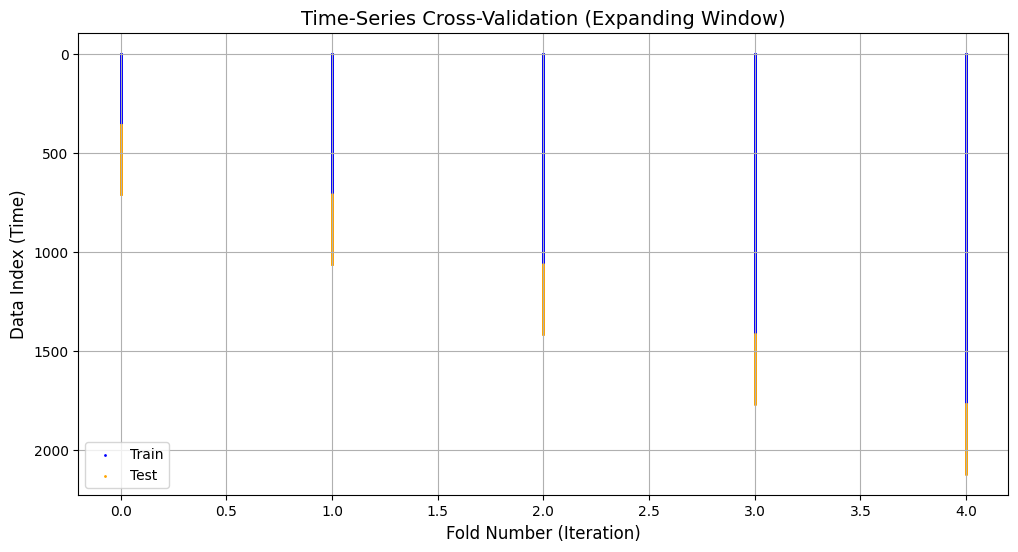

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# ASSUMPTION: You have already run the previous 'Data Transformation' step
# and have the variables 'X' and 'y' ready.
# ---------------------------------------------------------

# 1. Initialize the Splitter
# We use 5 splits as a standard starting point for cross-validation.
# This creates 5 separate test periods.
tscv = TimeSeriesSplit(n_splits=5)

print(f"Performing Time-Series Cross-Validation with {tscv.get_n_splits()} folds.\n")

# 2. Loop and Verify Dates (The "Logic Check")
fold = 1
for train_index, test_index in tscv.split(X):
    # Select data for this specific fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

    # Get the date ranges
    train_start, train_end = X_train.index.min(), X_train.index.max()
    test_start, test_end = X_test.index.min(), X_test.index.max()

    print(f"FOLD {fold}:")
    print(f"  TRAIN: {train_start.date()} -> {train_end.date()} (Size: {len(X_train)})")
    print(f"  TEST:  {test_start.date()} -> {test_end.date()} (Size: {len(X_test)})")

    # Validation Check: Ensure Train always ends before Test starts
    if train_end >= test_start:
        print("  >>> CRITICAL ERROR: Data Leakage detected!")
    else:
        print("  >>> VALID: No overlap.")
    print("-" * 40)
    fold += 1

# 3. Visualize the Split (The "Visual Check")
# This generates a chart to help you (and the professor) see the "Expanding Window".
plt.figure(figsize=(12, 6))
plt.title('Time-Series Cross-Validation (Expanding Window)', fontsize=14)

# Re-initialize to plot indices
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    # Plot Training Data (Blue)
    plt.scatter([i] * len(train_index), train_index, c='blue', s=1, label='Train' if i == 0 else "")
    # Plot Test Data (Orange)
    plt.scatter([i] * len(test_index), test_index, c='orange', s=1, label='Test' if i == 0 else "")

plt.ylabel('Data Index (Time)', fontsize=12)
plt.xlabel('Fold Number (Iteration)', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.gca().invert_yaxis() # Invert so Time 0 (Start) is at the top, or remove to have Time 0 at bottom
plt.show()

In [13]:
import numpy as np
import pandas as pd

# ==========================================
# PREPARE DATA FOR LSTM (RESHAPING)
# ==========================================

# 1. Convert DataFrame to NumPy Array
# LSTM libraries (TensorFlow/Keras) work best with raw arrays, not DataFrames.
X_array = X.values
y_array = y.values

# 2. Reshape for LSTM
# Format required: (Samples, Time Steps, Features)
# We use '1' for Time Steps because we already moved 'Time' into the 'Columns' (Lags).
samples = X_array.shape[0]
time_steps = 1
features = X_array.shape[1]

X_lstm = X_array.reshape(samples, time_steps, features)

# 3. Verification Check
print("------------------------------------------------")
print("Data Reshaping Complete")
print("------------------------------------------------")
print(f"Original X Shape (for XGB/KNN):  {X.shape}   -> 2D Matrix")
print(f"LSTM X Shape     (for Keras):    {X_lstm.shape} -> 3D Tensor")

# Safety Check:
if X_lstm.shape[0] == X.shape[0] and X_lstm.shape[2] == X.shape[1]:
    print(">>> SUCCESS: Dimensions match correctly.")
else:
    print(">>> ERROR: Dimensions got messed up during reshape.")

------------------------------------------------
Data Reshaping Complete
------------------------------------------------
Original X Shape (for XGB/KNN):  (2116, 53)   -> 2D Matrix
LSTM X Shape     (for Keras):    (2116, 1, 53) -> 3D Tensor
>>> SUCCESS: Dimensions match correctly.


In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Model Imports
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# ---------------------------------------------------------
# SETUP STORAGE
# ---------------------------------------------------------
# We will store results in a list and convert to DataFrame later
all_predictions = []

print(f"Starting Training on {tscv.get_n_splits()} Time-Series Folds...")
print("-" * 60)

# ---------------------------------------------------------
# MASTER LOOP
# ---------------------------------------------------------
fold = 1

for train_index, test_index in tscv.split(X):

    # 1. PREPARE DATA SLICES
    # -----------------------------------------------------
    # Standard Data (for XGB, LGBM, KNN)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # LSTM Data (Reshaped)
    X_train_lstm = X_lstm[train_index]
    X_test_lstm  = X_lstm[test_index]

    # Get Dates for this fold (for the CSV)
    test_dates = X_test.index

    print(f"Processing Fold {fold}...")

    # 2. DEFINE & TRAIN MODELS
    # -----------------------------------------------------

    # --- Model A: KNN (K-Nearest Neighbors) ---
    # Simple, distance-based.
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_train, y_train)
    pred_knn = knn.predict(X_test)

    # --- Model B: XGBoost ---
    # Gradient Boosting Tree
    xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb.fit(X_train, y_train)
    pred_xgb = xgb.predict(X_test)

    # --- Model C: LightGBM ---
    # Faster Gradient Boosting
    lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
    lgbm.fit(X_train, y_train)
    pred_lgbm = lgbm.predict(X_test)

    # --- Model D: ARIMA (Statistical) ---
    # ARIMA is unique; it usually works on just the history of 'y' (univariate).
    # We train on y_train and forecast len(y_test) steps ahead.
    # Order (5,1,0) is a standard starting point (AR=5, I=1, MA=0).
    try:
        arima_model = ARIMA(y_train, order=(5, 1, 0))
        arima_fit = arima_model.fit()
        # Forecast the next N steps (size of test set)
        pred_arima = arima_fit.forecast(steps=len(y_test))
        pred_arima = pred_arima.values # Convert to numpy array
    except:
        print("  -> ARIMA failed to converge, filling with NaNs")
        pred_arima = np.full(len(y_test), np.nan)

    # --- Model E: LSTM (Deep Learning) ---
    # Must rebuild model every fold to reset weights (prevent leakage)
    lstm_model = Sequential()
    # Input shape: (1, number_of_features)
    lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])))
    lstm_model.add(Dense(1)) # Output layer (1 price)
    lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

    # Train LSTM (verbose=0 to keep output clean)
    lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)
    pred_lstm = lstm_model.predict(X_test_lstm, verbose=0).flatten()

    # 3. SAVE RESULTS
    # -----------------------------------------------------
    # Create a mini-dataframe for this fold's results
    fold_results = pd.DataFrame({
        'Date': test_dates,
        'Actual_Price': y_test.values,
        'Pred_KNN': pred_knn,
        'Pred_XGB': pred_xgb,
        'Pred_LGBM': pred_lgbm,
        'Pred_ARIMA': pred_arima,
        'Pred_LSTM': pred_lstm,
        'Fold_ID': fold
    })

    all_predictions.append(fold_results)

    fold += 1

# ---------------------------------------------------------
# FINALIZE & EXPORT
# ---------------------------------------------------------
# Combine all folds into one big DataFrame
final_predictions = pd.concat(all_predictions)
final_predictions.set_index('Date', inplace=True)

# Save to CSV (Role 2 Deliverable)
output_filename = 'predictions.csv'
final_predictions.to_csv(output_filename)

print("-" * 60)
print(f"SUCCESS! All models trained. Results saved to '{output_filename}'.")
print("Sample of results:")
print(final_predictions.head())

Starting Training on 5 Time-Series Folds...
------------------------------------------------------------
Processing Fold 1...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing Fold 2...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing Fold 3...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing Fold 4...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing Fold 5...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


------------------------------------------------------------
SUCCESS! All models trained. Results saved to 'predictions.csv'.
Sample of results:
            Actual_Price  Pred_KNN  Pred_XGB  Pred_LGBM  Pred_ARIMA  \
Date                                                                  
2020-12-31     -0.535344 -0.589026 -0.552111  -0.670465   -0.542471   
2021-01-01     -0.443565 -0.589026 -0.552111  -0.674134   -0.538650   
2021-01-02     -0.418766 -0.589026 -0.552132  -0.637820   -0.532876   
2021-01-03     -0.449094 -0.589026 -0.552079  -0.647228   -0.529895   
2021-01-04     -0.385318 -0.589026 -0.552459  -0.635754   -0.528656   

            Pred_LSTM  Fold_ID  
Date                            
2020-12-31  -0.608528        1  
2021-01-01  -0.588591        1  
2021-01-02  -0.562214        1  
2021-01-03  -0.525864        1  
2021-01-04  -0.511986        1  


In [16]:
# ---------------------------------------------------------
# FINALIZE & EXPORT PART 1: NORMALIZED (REQUIRED)
# ---------------------------------------------------------
# Combine all folds into one big DataFrame
final_predictions = pd.concat(all_predictions)
final_predictions.set_index('Date', inplace=True)

# 1. Save the NORMALIZED version (The Role 2 Deliverable)
norm_filename = 'predictions.csv'
final_predictions.to_csv(norm_filename)
print(f"SUCCESS: Normalized results saved to '{norm_filename}'")

# ---------------------------------------------------------
# FINALIZE & EXPORT PART 2: DE-NORMALIZED (EXTRA HELPFUL)
# ---------------------------------------------------------
# Create a copy so we don't mess up the original data in memory
denorm_df = final_predictions.copy()

# === CRITICAL: ENTER THE VALUES FROM ROLE 1 HERE ===
# You must replace these 0.0 values with the actual stats used by Role 1.
# If you don't have them yet, ask Role 1:
# "What was the mean and std dev of the 'Close' column?"
original_mean = 53033.338877  # e.g., 45000.50
original_std  = 29397.825835  # e.g., 15000.20

print(f"\nGeneratiing De-normalized file using Mean: {original_mean} | Std: {original_std}...")

# Function to Reverse Z-Score: x = (z * std) + mean
def inverse_transform(z_score):
    return (z_score * original_std) + original_mean

# Apply to all price columns
price_cols = ['Actual_Price', 'Pred_KNN', 'Pred_XGB', 'Pred_LGBM', 'Pred_ARIMA', 'Pred_LSTM']

for col in price_cols:
    denorm_df[col] = inverse_transform(denorm_df[col])

# 2. Save the DE-NORMALIZED version (For Role 3's Paper/Charts)
denorm_filename = 'predictions_denormalized.csv'
denorm_df.to_csv(denorm_filename)

print(f"SUCCESS: De-normalized (USD) results saved to '{denorm_filename}'")
print("-" * 60)
print("Sample of Real USD Prices:")
print(denorm_df[['Actual_Price', 'Pred_LSTM']].head())

SUCCESS: Normalized results saved to 'predictions.csv'

Generatiing De-normalized file using Mean: 53033.338877 | Std: 29397.825835...
SUCCESS: De-normalized (USD) results saved to 'predictions_denormalized.csv'
------------------------------------------------------------
Sample of Real USD Prices:
            Actual_Price     Pred_LSTM
Date                                  
2020-12-31  37295.387765  35143.925781
2021-01-01  39993.488798  35730.031250
2021-01-02  40722.530286  36505.476562
2021-01-03  39830.939971  37574.078125
2021-01-04  41705.822136  37982.066406
